In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*--------  HANTS code  --------*-*-*-*-*-*-----

# Computing diagonal for each row of a 2d array. See: http://stackoverflow.com/q/27214027/2459096
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in xrange(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    return mat        

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Hi',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    """

    # define some parameters
    base_period_len = sample_count*2  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in xrange(sample_count):
        if ready.all():
            break
        # print '--------*-*-*-*',it.value, '*-*-*-*--------'
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    return outputs


# Compute semi-random time series array with numb standing for number of timeseries
def array_in(numb):
    y = np.array([5.0, 2.0, 10.0, 12.0, 18.0, 23.0, 27.0, 40.0, 60.0, 70.0, 90.0, 160.0, 190.0,
                  210.0, 104.0, 90.0, 170.0, 50.0, 120.0, 60.0, 40.0, 30.0, 28.0, 24.0, 15.0,
                  10.0])
    y = np.tile(y[None].T, (1, numb)).T
    kl = (np.random.randint(2, size=(numb, 26)) *
          np.random.randint(2, size=(numb, 26)) + 1)
    kl[kl == 2] = 0
    y = y * kl
    return y

In [3]:
file_in = r'D:\Downloads\ZhouJie@Mattijn//MODIS-8day-ndvi_2.xlsx'
df_myd = pd.read_excel(file_in, sheetname=0, header=0)
df_mod = pd.read_excel(file_in, sheetname=1, header=0)

In [4]:
timestamps = []
for idx, val in enumerate(df_myd['system:index']):
    year = val[-12:-8]
    month = val[-7:-5]
    day = val[-4:-2]
    #print i[-4:-2]
    #pd.Timestamp()
    date = pd.Timestamp(year+'-'+month+'-'+day)
    timestamps.append(date)
    #df['system:index'][idx] = date
df_myd['timestamps'] = timestamps    
#df_myd = df_myd.set_index(['timestamps','LC_type'])

timestamps = []
for idx, val in enumerate(df_mod['system:index']):
    year = val[-12:-8]
    month = val[-7:-5]
    day = val[-4:-2]
    #print i[-4:-2]
    #pd.Timestamp()
    date = pd.Timestamp(year+'-'+month+'-'+day)
    timestamps.append(date)
    #df['system:index'][idx] = date
df_mod['timestamps'] = timestamps    
#df_mod = df_mod.set_index(['timestamps','LC_type'])
df_mod_myd = pd.concat([df_mod,df_myd])
df_mod_myd.set_index(['timestamps','LC_type'], inplace=True)
df_mod_myd.sortlevel(inplace=True)

In [5]:
# Rainfed_croplands
df_RC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Rainfed_croplands']
df_RC.reset_index(inplace=True)
df_RC.set_index('timestamps', inplace=True)

# Mosaic_cropland_vegetation
df_MC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_cropland_vegetation']
df_MC.reset_index(inplace=True)
df_MC.set_index('timestamps', inplace=True)

# Mosaic_cropland_vegetation
df_MC = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_cropland_vegetation']
df_MC.reset_index(inplace=True)
df_MC.set_index('timestamps', inplace=True)

# Mosaic_vegetation_cropland
df_MV = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Mosaic_vegetation_cropland']
df_MV.reset_index(inplace=True)
df_MV.set_index('timestamps', inplace=True)

# Open_needleleaved_deciduous_evergreen_forest
df_ON = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Open_needleleaved_deciduous_evergreen_forest']
df_ON.reset_index(inplace=True)
df_ON.set_index('timestamps', inplace=True)

# Closed_to_open_herbaceous_vegetation
df_CO = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Closed_to_open_herbaceous_vegetation']
df_CO.reset_index(inplace=True)
df_CO.set_index('timestamps', inplace=True)

# Sparse_vegetation
df_SV = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Sparse_vegetation']
df_SV.reset_index(inplace=True)
df_SV.set_index('timestamps', inplace=True)

# Bare_areas
df_BA = df_mod_myd.loc[df_mod_myd.index.get_level_values('LC_type') == 'Bare_areas']
df_BA.reset_index(inplace=True)
df_BA.set_index('timestamps', inplace=True)

In [6]:
np.unique(df_mod_myd.index.get_level_values('LC_type'))

array([u'Bare_areas', u'Closed_to_open_herbaceous_vegetation',
       u'Mosaic_cropland_vegetation', u'Mosaic_vegetation_cropland',
       u'Open_needleleaved_deciduous_evergreen_forest',
       u'Rainfed_croplands', u'Sparse_vegetation'], dtype=object)

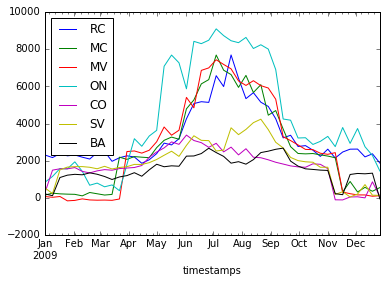

In [7]:
period = '2009'
df_RC['NDVI'][period].plot(style='-', label = 'RC', legend=True)
df_MC['NDVI'][period].plot(style='-', label = 'MC', legend=True)
df_MV['NDVI'][period].plot(style='-', label = 'MV', legend=True)
df_ON['NDVI'][period].plot(style='-', label = 'ON', legend=True)
df_CO['NDVI'][period].plot(style='-', label = 'CO', legend=True)
df_SV['NDVI'][period].plot(style='-', label = 'SV', legend=True)
df_BA['NDVI'][period].plot(style='-', label = 'BA', legend=True)

In [8]:
# RC
y_RC = df_RC['NDVI'][period].as_matrix()[None]
y_RC_HANTS = HANTS(y_RC.shape[-1], y_RC, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# MC
y_MC = df_MV['NDVI'][period].as_matrix()[None]
y_MC_HANTS = HANTS(y_MC.shape[-1], y_MC, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# MV
y_MV = df_MV['NDVI'][period].as_matrix()[None]
y_MV_HANTS = HANTS(y_MV.shape[-1], y_MV, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# ON
y_ON = df_ON['NDVI'][period].as_matrix()[None]
y_ON_HANTS = HANTS(y_ON.shape[-1], y_ON, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# CO
y_CO = df_CO['NDVI'][period].as_matrix()[None]
y_CO_HANTS = HANTS(y_CO.shape[-1], y_CO, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# SV
y_SV = df_SV['NDVI'][period].as_matrix()[None]
y_SV_HANTS = HANTS(y_SV.shape[-1], y_SV, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

# BA
y_BA = df_BA['NDVI'][period].as_matrix()[None]
y_BA_HANTS = HANTS(y_BA.shape[-1], y_BA, 6, outliers_to_reject='Lo', low=-2000, 
                   high = 10000, fit_error_tolerance=500)

In [13]:
y_BA_HANTS

array([[  168.98389078,   510.47910757,   824.20569651,  1077.60684076,
         1250.77647904,  1338.34099911,  1348.99897915,  1302.91837702,
         1227.52025145,  1152.41048552,  1104.32158969,  1102.88339082,
         1157.86603907,  1268.2644659 ,  1423.26883668,  1604.84634522,
         1791.39921138,  1961.80405666,  2099.10297915,  2193.20892292,
         2242.18792646,  2251.95111969,  2234.48118628,  2204.979894  ,
         2178.5097953 ,  2166.78273534,  2175.70792816,  2204.16172336,
         2244.20783456,  2282.72316908,  2304.11981708,  2293.64581289,
         2240.63348921,  2141.06548169,  1998.94525751,  1826.17148416,
         1640.88656359,  1464.55142698,  1318.24094376,  1218.81306451,
         1175.65014918,  1188.59232441,  1247.49119677,  1333.53879878,
         1422.21714656,  1487.42136386]])

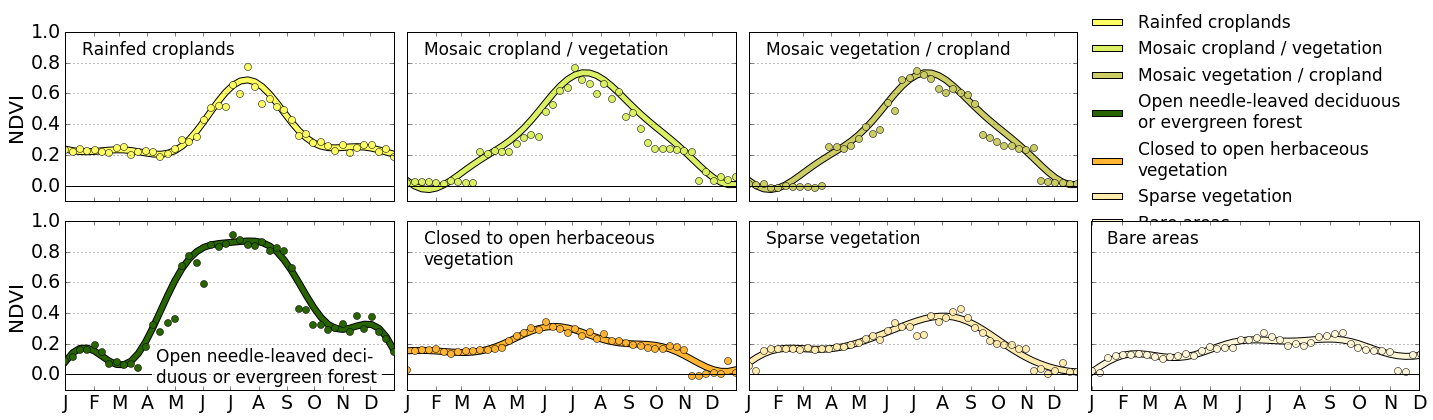

In [76]:
set_lw1 = 5
set_lw2 = 7
# row and column sharing
from matplotlib import dates
import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
plt.rcParams.update({'axes.labelsize': 'large'})
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, sharex='col', sharey='row', 
                                                               figsize=(20,5.7))
#ax1.plot(df_RC['NDVI'][period].index.astype(datetime),y_RC_HANTS[0]/10000., 'k', lw=3,label='Low')
ax1.plot(df_RC['NDVI'][period].index.astype(datetime),y_RC_HANTS[0]/10000., '#ffff64', lw=set_lw1,label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
ax1.plot(df_RC['NDVI'][period].index.astype(datetime),df_RC['NDVI'][period]/10000.,color='#ffff64',
         linestyle='None',marker='o', markersize=set_lw2,label='RC')
L_RC = mlines.Line2D([], [], color='#ffff64', lw=set_lw1, label='Rainfed croplands',
                     path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
ax1.set_ylim(-0.1,1)
ax1.axhline(color='k')
ax1.xaxis_date()
ax1.yaxis.grid()
ax1.set_ylabel('NDVI', fontsize=20)
# ax1.xaxis.set_major_locator(dates.MonthLocator(interval=1))
# ax1.xaxis.set_minor_locator(dates.MonthLocator())
# ax1.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.tick_params(axis='both', which='major', labelsize=19)
ax1.text(0.05, 0.95, 'Rainfed croplands', transform=ax1.transAxes, 
        fontsize=17, verticalalignment='top')


#ax2.plot(df_MC['NDVI'][period].index.astype(datetime),y_MC_HANTS[0]/10000., 'k', lw=3,label='Low')
ax2.plot(df_MC['NDVI'][period].index.astype(datetime),y_MC_HANTS[0]/10000., '#dcf064', lw=set_lw1, label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])         
ax2.plot(df_MC['NDVI'][period].index.astype(datetime),df_MC['NDVI'][period]/10000., color='#dcf064',
         linestyle='None',marker='o', markersize=set_lw2,label='MC')
L_MC = mlines.Line2D([], [], color='#dcf064', lw=set_lw1, label='Mosaic cropland / vegetation',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax2.set_ylim(-0.1,1)
ax2.axhline(color='k')
ax2.xaxis_date()
ax2.yaxis.grid()
# ax2.xaxis.set_major_locator(dates.MonthLocator(interval=1))
# ax2.xaxis.set_minor_locator(dates.MonthLocator())
# ax2.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.tick_params(axis='both', which='major', labelsize=19)
ax2.text(0.05, 0.95, 'Mosaic cropland / vegetation', transform=ax2.transAxes, 
        fontsize=17, verticalalignment='top')



#ax3.plot(df_MV['NDVI'][period].index.astype(datetime),y_MV_HANTS[0]/10000., 'k', lw=3,label='Low')
ax3.plot(df_MV['NDVI'][period].index.astype(datetime),y_MV_HANTS[0]/10000., '#cdcd66', lw=set_lw1,label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
         
ax3.plot(df_MV['NDVI'][period].index.astype(datetime),df_MV['NDVI'][period]/10000., color='#cdcd66', 
         linestyle='None', marker='o', markersize=set_lw2,label='MV')
L_MV = mlines.Line2D([], [], color='#cdcd66', lw=set_lw1, label='Mosaic vegetation / cropland',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax3.set_ylim(-0.1,1)
ax3.axhline(color='k')
ax3.xaxis_date()
ax3.yaxis.grid()
# ax3.xaxis.set_major_locator(dates.MonthLocator(interval=1))
# ax3.xaxis.set_minor_locator(dates.MonthLocator())
# ax3.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax3.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax3.tick_params(axis='both', which='major', labelsize=19)
ax3.text(0.05, 0.95, 'Mosaic vegetation / cropland', transform=ax3.transAxes, 
        fontsize=17, verticalalignment='top')


#ax5.plot(df_ON['NDVI'][period].index.astype(datetime),y_ON_HANTS[0]/10000., 'k', lw=3, label='Low')
ax5.plot(df_ON['NDVI'][period].index.astype(datetime),y_ON_HANTS[0]/10000., '#286400', lw=set_lw1,label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()], zorder=10)
         
ax5.plot(df_ON['NDVI'][period].index.astype(datetime),df_ON['NDVI'][period]/10000.,color='#286400', 
         linestyle='None',marker='o', markersize=set_lw2,label='ON', zorder=10)
L_ON = mlines.Line2D([], [], color='#286400', lw=set_lw1, label='Open needle-leaved deciduous \nor evergreen forest',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax5.set_ylim(-0.1,1)
ax5.axhline(color='k')
ax5.xaxis_date()
ax5.yaxis.grid()
ax5.set_ylabel('NDVI', fontsize=20)
ax5.tick_params(axis='both', which='major', labelsize=19)
ax5.text(0.275, 0.25, 'Open needle-leaved deci-\nduous or evergreen forest', transform=ax5.transAxes, 
        fontsize=17, verticalalignment='top', backgroundcolor='white', zorder=2)

       

#ax6.plot(df_CO['NDVI'][period].index.astype(datetime),y_CO_HANTS[0]/10000., 'k', lw=3, label='Low')
ax6.plot(df_CO['NDVI'][period].index.astype(datetime),y_CO_HANTS[0]/10000., '#ffb432', lw=set_lw1,label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
         
ax6.plot(df_CO['NDVI'][period].index.astype(datetime),df_CO['NDVI'][period]/10000.,color='#ffb432', 
         linestyle='None', marker='o', markersize=set_lw2, label='CO')
L_CO = mlines.Line2D([], [], color='#ffb432', lw=set_lw1, label='Closed to open herbaceous \nvegetation',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax6.set_ylim(-0.1,1)
ax6.axhline(color='k')
ax6.xaxis_date()
ax6.yaxis.grid()
ax6.tick_params(axis='both', which='major', labelsize=19)
ax6.text(0.05, 0.95, 'Closed to open herbaceous \nvegetation', transform=ax6.transAxes, 
        fontsize=17, verticalalignment='top')


#ax7.plot(df_SV['NDVI'][period].index.astype(datetime),y_SV_HANTS[0]/10000., 'k', lw=3,label='Low')
ax7.plot(df_SV['NDVI'][period].index.astype(datetime),y_SV_HANTS[0]/10000., '#ffebaf', lw=set_lw1, label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
         
ax7.plot(df_SV['NDVI'][period].index.astype(datetime),df_SV['NDVI'][period]/10000., color='#ffebaf',
         linestyle='None', marker='o', markersize=set_lw2, label='SV')
L_SV = mlines.Line2D([], [], color='#ffebaf', lw=set_lw1, label='Sparse vegetation',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax7.set_ylim(-0.1,1)
ax7.axhline(color='k')
ax7.xaxis_date()
ax7.yaxis.grid()
ax7.tick_params(axis='both', which='major', labelsize=19)
ax7.text(0.05, 0.95, 'Sparse vegetation', transform=ax7.transAxes, 
        fontsize=17, verticalalignment='top')


#ax8.plot(df_BA['NDVI'][period].index.astype(datetime),y_BA_HANTS[0]/10000., 'k', lw=3, label='Low')
ax8.plot(df_BA['NDVI'][period].index.astype(datetime),y_BA_HANTS[0]/10000., '#fff5d7', lw=set_lw1, label='Low',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
         
ax8.plot(df_BA['NDVI'][period].index.astype(datetime),df_BA['NDVI'][period]/10000.,color='#fff5d7', 
         linestyle='None', marker='o', markersize=set_lw2,label='BA')
L_BA = mlines.Line2D([], [], color='#fff5d7', lw=set_lw1, label='Bare areas',
        path_effects=[path_effects.Stroke(linewidth=set_lw2, foreground='black'),
                       path_effects.Normal()])
                     
ax8.set_ylim(-0.1,1)
ax8.set_xlim('2008-12-31','2009-12')
ax8.axhline(color='k')
ax8.xaxis_date()
ax8.yaxis.grid()
ax8.xaxis.set_major_locator(dates.MonthLocator(interval=1))
# ax8.xaxis.set_minor_locator(dates.MonthLocator())
# ax8.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
ax8.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax8.tick_params(axis='both', which='major', labelsize=19)
ax8.text(0.05, 0.95, 'Bare areas', transform=ax8.transAxes, 
        fontsize=17, verticalalignment='top')

#f.autofmt_xdate()
x_value = .014
y_value = .55
blue_line = mlines.Line2D((0,1),(0,0), color='blue', label='My Label')
reds_line = mlines.Line2D([], [], color='red', label='My Othes')

leg = ax4.legend(handles=[L_RC,L_MC,L_MV,L_ON,L_CO,L_SV,L_BA], 
                 loc=2, bbox_to_anchor=(-0.05, 1.20), fontsize=17)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('w')
ax4.axis('off')
#f.legend()#handles=[l1,l2,l3,l8,l5,l6,l7],loc='upper right')#, loc = (axbox.x0 + x_value, axbox.y0 + y_value))
f.tight_layout()
f.savefig(r'D:\Downloads\Libraries_documents\HOME\Figures paper//hants_2009.png', dpi=400, 
         pad_inches=0.5)

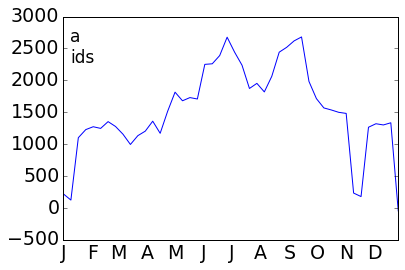

In [65]:
ax = plt.subplot(111)#host_subplot(111, axes_class=AA.Axes)
ax.plot(df_BA['NDVI'][period].index,df_BA['NDVI'][period])##.plot(style='-', label = 'BA', legend=True)
#ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('%b\n%Y'))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.tick_params(axis='both', which='major', labelsize=19)
# place a text box in upper left in axes coords
ax.text(0.02, 0.95, 'a \nids', transform=ax.transAxes, 
        fontsize=17, verticalalignment='top')

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe

# setup data
x = np.arange(0.0, 1.0, 0.01)
y = np.sin(2*2*np.pi*t)

# create line plot including an outline (stroke) using path_effects
plt.plot(x, y, color='k', lw=2, path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()])
# custom plot settings
plt.grid(True)
plt.ylim((-2, 2))
plt.legend(['sine'])
plt.savefig(r'D:\GoogleChromeDownloads\MyWebSites\100vragenKNS\toetskns.nl//sin1.png')
plt.show()

In [ ]:
# create line plot including an simple line shadow using path_effects
plt.plot(x, y, color='k', lw=2, path_effects=[pe.SimpleLineShadow(shadow_color='g'), pe.Normal()])
# custom plot settings
plt.grid(True)
plt.ylim((-2, 2))
plt.legend(['sine'])
plt.savefig(r'D:\GoogleChromeDownloads\MyWebSites\100vragenKNS\toetskns.nl//sin2.png')
plt.show()
